<h1><center>Milestone 2</center></h1>
<h2><center>Rami Pellumbi (rp534)</center></h2>

<h2><center>Instructions</center></h2>
You will submit a Jupyter notebook that implements following instructions. You are allowed to use built-in or already available functions for spatial transformation and optimization.
<br>
1. Write a function that computes a 4-parameter geometric registration (global scale, rotation, and translations along two axes) between two mid-coronal MRI slices from two different subjects (a fixed image and a moving image). This step will consists of following sub-steps.
<br>
– a function that takes in an input (moving) image, 4 transformation parameters (global scale, rotation, and translations along two axes) and output (fixed image) grid size, and computes the output (moved) image. The output image has a size of the output grid size and pixel values are obtained by resampling the input image onto the output grid via applying the geometric transformation: a global scale multiplied with a rotation matrix, followed by a translation. Outside-of-grid-range values can default to zero.
<br>
– a loss function that takes three inputs: a length-4 vector of geometric transformation parameters, a fixed image, and a moving image. The output should be equal to the sum of squared differences between the geometrically trans- formed moved image and the fixed image.
<br>
– an optimization module that minimizes the loss function for a given input image pair (fixed and moving). This module should return two things: the transformed moving image and the optimal geometric transformation parameters.
<br>
2. Use your registration tool to resample each training image (moving) onto each validation image (fixed) (i.e., you need to run 12 registration instances). Visualize some slices of these results. You need to show that your registration works - i.e., plot results for before the registration and after the registration.
<br>
3. Apply the registration results (optimal transformations) to resample the manual segmentations of each training subject onto the validation subject grids (use nearest neighbor interpolation)
<br>
4. For every pixel on validation subject grid, compute the most frequent training label – this is called majority voting based label fusion. You can implement any tie-break strategy you want. This is a crude segmentation of the validation subjects.
<br>
5. Write a function that computes the Jaccard overlap index for a given region of interest (ROI) between an input manual segmentation and an automatic segmentation. The Jaccard index is defined as the ratio between the area of the intersection and the area of the union, where the intersection and union are defined with respect to the manual segmentation and an automatic segmentation.
<br>
6. Compute the Jaccard index for your automatic validation subject segmentations. Compile these in a table and print. Only consider following regions of interest (both left and right): Cerebral-White-Matter and Cerebral-Cortex.

In [1]:
#Pesky import stuff
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
import cmath
import nibabel as nib
import random
import cv2
import scipy
from scipy import ndimage
from scipy import signal
from scipy import stats

<h2><center>Load Images</center></h2>

### Function to get the Middle coronal slice of a nib_img

Website for slice information: https://faculty.washington.edu/chudler/slice.html

In [2]:
"""MiddleCoronalSlice takes a nib_img and returns its coronal slice"""
def MiddleCoronalSlice(nib_img):
    nib_img_data = nib_img.get_fdata()
    coronal_slice = nib_img_data[:, :, len(nib_img_data[0][0])//2]
    #rotate the slice 90 degrees so it looks more like the websites photo
    return ndimage.rotate(coronal_slice, 90)

### Use following cell on Windows

In [3]:
# #Location of training images and segments to load (Windows)
# training_images_dir = [r'C:\Users\Rami Pellumbi\Desktop\DSP_PROJECT_DATA\Training\IBSR_0'+ str(i) + r'\images\analyze\IBSR_0' + str(i) + r'_ana.img' for i in range(1,7)]
# training_segments_dir = [r'C:\Users\Rami Pellumbi\Desktop\DSP_PROJECT_DATA\Training\IBSR_0'+ str(i) + r'\segmentation\analyze\IBSR_0' + str(i) + r'_seg_ana.img' for i in range(1,7)]

# #location of validation images and segments to load(Windows)
# validation_images_dir = [r'C:\Users\Rami Pellumbi\Desktop\DSP_PROJECT_DATA\Validation\IBSR_'+ i + r'\images\analyze\IBSR_' + i + r'_ana.img' for i in ['07', '15']]
# validation_segments_dir = [r'C:\Users\Rami Pellumbi\Desktop\DSP_PROJECT_DATA\Validation\IBSR_'+ i + r'\segmentation\analyze\IBSR_' + i + r'_seg_ana.img' for i in ['07', '15']]

# #location of testing images
# testing_images_loc = ['08','09','10','11','12','13','14','16','17']

# #where the directory of testing images will be stored
# testing_images_dir = []

# for loc in testing_images_loc:
#     testing_images_dir.append(r'C:\Users\Rami Pellumbi\Desktop\DSP_PROJECT_DATA\Testing\IBSR_'+ loc + r'\images\analyze\IBSR_' + loc + '_ana.img')

# #arrays of training images and segments
# training_images = []
# training_segments = []

# #arrays of validation images and segments
# validation_images = []
# validation_segments = []

# #array of testing images
# testing_images = []

# #BY DEFINITION there are an equal amount of images as there are segments so arrays are the same size and can therefore be 

# #load up all the training images and segments in order
# for i in range(len(training_images_dir)):
#     training_images.append(MiddleCoronalSlice(nib.load(training_images_dir[i])))
#     training_segments.append(MiddleCoronalSlice(nib.load(training_segments_dir[i])))

# #load up all the validation images in order
# for i in range(len(validation_images_dir)):
#     validation_images.append(MiddleCoronalSlice(nib.load(validation_images_dir[i])))
#     validation_segments.append(MiddleCoronalSlice(nib.load(validation_segments_dir[i])))

# #load up all testing images in order
# for directory in testing_images_dir:
#     testing_images.append(MiddleCoronalSlice(nib.load(directory)))

### Use following cell on OSX

In [4]:
training_images_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Training/IBSR_0'+ str(i) + '/images/analyze/IBSR_0' + str(i) +'_ana.img' for i in range(1,7)]
training_segments_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Training/IBSR_0'+ str(i) + '/segmentation/analyze/IBSR_0' + str(i) +'_seg_ana.img' for i in range(1,7)]

validation_images_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Validation/IBSR_'+ i + '/images/analyze/IBSR_' + i +'_ana.img' for i in ['07', '15']]
validation_segments_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Validation/IBSR_'+ i + '/segmentation/analyze/IBSR_' + i +'_seg_ana.img' for i in ['07', '15']]

#location of testing images
testing_images_loc = ['08','09','10','11','12','13','14','16','17']

#where the directory of testing images will be stored
testing_images_dir = []

for loc in testing_images_loc:
    testing_images_dir.append('/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Testing/IBSR_'+ loc + '/images/analyze/IBSR_' + loc + '_ana.img')

#arrays of middle coronal slices of training images and segments
training_images = []
training_segments = []

#arrays of middle coronal slices of validation images and segments
validation_images = []
validation_segments = []

#array of middle coronal slice of testing images
testing_images = []

#BY DEFINITION there are an equal amount of images as there are segments so arrays are the 
#same size and can therefore be grouped together

#load up all the training images and segments in order
for i in range(len(training_images_dir)):
    training_images.append(MiddleCoronalSlice(nib.load(training_images_dir[i])))
    training_segments.append(MiddleCoronalSlice(nib.load(training_segments_dir[i])))

#load up all the validation images in order
for i in range(len(validation_images_dir)):
    validation_images.append(MiddleCoronalSlice(nib.load(validation_images_dir[i])))
    validation_segments.append(MiddleCoronalSlice(nib.load(validation_segments_dir[i])))

#load up all testing images in order
for directory in testing_images_dir:
    testing_images.append(MiddleCoronalSlice(nib.load(directory)))

#### Convention: M is the amount of columns, N is the amount of rows. In (x,y)-grid sense this means each m in [M] represents an x-coordinate, and each n in [N] represents a y-coordinate.

#### Moving image -> training images, Fixed images -> validation images

<h2><center>1: 4 Parameter Geometric Registration</center></h2>

#### Sub Functions

In [5]:
"""
Input(s): -moving image
          -A: a global scalar - type float
          -theta: rotation angle in degrees; 0<=theta<=360
          -t_x = d_m: translation on x-axis - type int
          -t_y = d_n: translation on y-axis - type int
          -out_size: ouput (fixed image) grid size - i.e an array in terms of fixed_image.shape (height,width)

Output image has a size of the output grid size and pixel values are obtained by resampling the input image onto 
the output grid via applying the geometric transformation:
    1)Global scale multiplied with a rotation matrix
    2)Translation

Returns: transf_img: the output as a result of applying geometric transformation to input image 
                     (out of range values default to 0)
"""
def Transformer(moving_img, A, theta, d_m, d_n, out_grid_size):
    #y(m,n) = x(T(m,n)) where T(m,n) = aR[[m],[n]] + [[dm],[dn]]
    
    ih,iw = len(moving_img), len(moving_img[0])
    #get height(N) and width(M) of output image from input paramater out_grid_size
    oh, ow = out_grid_size[0], out_grid_size[1]
    
    """M1 is the matrix defined by
                getRotationMatrix2D(coordinate, angle to rotate by, scalar)
       which computes a 2x3 affine matrix for 2D rotation where the matrix is
                   [[alpha, Beta,  (1-alpha)*coordinate.x - Beta*coordinate.y],
                    [-Beta, alpha, Beta*coordinate.x + (1-alpha)*coordinate.y]]
       where 
                    alpha = scalar*cos(theta), Beta = scalar*sin(theta)
    """
    M1 = cv2.getRotationMatrix2D((iw//2,ih/2),theta,A) #want to rotate about center so iw//2, ih//2
    #apply the affine matrix M1 to input moving image
    scaled_rotated_img = cv2.warpAffine(moving_img,M1,(ow,oh)) 
    
    """M2 is the 2x3 affine matrix 
                                    [[1, 0, translation_x],
                                     [0, 1, translation_y]]
       which translates the image along the x,y axis when using cv2's warpAffine function
    """
    M2 = np.float32([[1,0,d_m],
                     [0,1,d_n]])
    #apply the affine matrix M2 to the scaled rotated image
    translated_img = cv2.warpAffine(scaled_rotated_img,M2,(ow,oh)) #translate the scaled and rotated image
    
    #The translated image has had all of the transformations applied, so I return that
    return translated_img

In [6]:
# p = validation_images[0]
# print(p[255][255][0])

In [7]:
#Quick little verification
# a = Transformer(training_images[0],2, 90, -0, 0,(512,512))
# b = Transformer(training_images[0],2, 90, 0, 0,(256,256))
# plt.figure(1)
# plt.imshow(a.squeeze(), cmap = 'gray', origin="lower")
# plt.figure(2)
# plt.imshow(b.squeeze(), cmap = 'gray', origin="lower")

In [8]:
"""
Input(s): -Params (a length-4 vector of geometric transformation parameters) - i.e an array of (A, theta, t_x, t_y)
          -fixed image 
          -moving image
Returns: sum of squared differences between the geometrically transformed moving image and the fixed image
"""
def Loss(Params, fixed_img, moving_img):    
    #compute geometrically transformed image using input parameters
    gt_img = Transformer(moving_img, *Params, fixed_img.shape) # *Params unpacks the array
    
    #make input images np arrays for easier and faster calculations
    im1 = np.array(np.ndarray.flatten(fixed_img))
    im2 = np.array(np.ndarray.flatten(gt_img))
    
    #np.sum sums all the elements in array where the i'th element is (im1[i]-im2[i])^2
    output = np.sum(np.power(im1-im2,2))       
    
    #Sum of squared differences between 2d images A and B := np.sum((A[m][n] - B[m][n])**2)
    return output/1e7

In [9]:
# s = Loss((1,0,0,0), training_images[0], validation_images[0])
# print(s)

In [10]:
"""
Optimizer computes the optimal geometric transformation parameters, and returns them alongside the 
geometric transformation of the geometric image with those parameters

Input(s): -fixed image
          -moving image
Returns:
          -optimal_params: optimal geometric transformation parameters
          -transf_img: geometrically transformed moving image with optimal_params
"""
def Optimize(fixed_img, moving_img):
    
    #optimized parameters will be 
    opt_params = scipy.optimize.fmin(Loss, (1,0,0,0), args=(fixed_img, moving_img))
    transf_img = Transformer(moving_img, *opt_params, fixed_img.shape)
    return opt_params, transf_img

In [11]:
# test_img = Transformer(training_images[0], 1, 25, 5, 5, validation_images[0].shape)

# op, oi = Optimize(validation_images[0],training_images[0])

# op, oi = Optimize(validation_images[0],training_images[0])

In [12]:
# print(op)
# plt.figure(1)
# plt.imshow(oi, cmap = 'gray', origin = 'lower')
# plt.figure(2)
# plt.imshow(test_img.squeeze(), cmap = 'gray', origin = 'lower')
# plt.figure(3)
# plt.imshow(training_images[0].squeeze(), cmap = 'gray', origin = 'lower')

# a = Transformer(training_images[0], *op, validation_images[0].shape)
# plt.figure(4)
# plt.imshow(a.squeeze(), cmap = 'gray', origin = 'lower')

#### Geometric Registration Function

In [13]:
"""
Geometric differs from Optimize in the fact that it optimizes the normalized fixed and moving images beo
Input(s): -fixed image
          -moving image
Returns:  -geometrically transformed moving image using optimal parameters
"""
def geometricRegistration(fixed_img, moving_img):
    #get height (N) and width(M) of fixed image 
    height,width,c = fixed_img.shape
    
    #initialize an array of zeros of size MxN
    normalizedImg = np.zeros((height,width))
    #compute the normalized fixed image
    normalized_fixed_img = cv2.normalize(fixed_img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
    
    #initialize an array of zeros of size MxN
    normalizedImg = np.zeros((height,width))
    #compute the normalized moving image
    normalized_moving_img = cv2.normalize(moving_img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
    
    #compute optimal parameters, and the geometric transformed image with these optimal parameters
    opt_params, transf_img = Optimize(normalized_fixed_img,normalized_moving_img)
    
    #return the geometrically transformed image with optimal paramenters
    return opt_params, transf_img

<h2><center>2: Resampling each Training Image (moving) Onto Each Validation Image (fixed)</center></h2>

In [14]:
"""
transf_img[k] is the optimally transformed image from geometrickRegistration(fixed_img[j], moving_img[i])
for each valid indices i,j - where i,j integers such that 0<=j<=1, 0<=i<=5.

Thus k is an integer such that 0<=k<=11 and there are 12 total transformed images
with a corresponding optimal transform

geometricRegistration(fixed_img[0], moving_img[i]) for i in range(6) -> transf_img[k] for k in range(6)
geometricRegistration(fixed_img[1], moving_img[i]) for i in range(6) -> transf_img[k] for k in range(6,12)

opt_params[k] has the same invariant
"""
opt_params = []
transf_img = []

#for each validation image (j = 0,1)
for fixed_img in validation_images:
    #for each moving image (i = 0,1,2,3,4,5)
    for moving_img in training_images: 
        op, tf = geometricRegistration(fixed_img, moving_img)
        opt_params.append(op)
        #append the geometricRegistration(fixed_img,moving_img) to transf_img by invariant above
        transf_img.append(tf)

Optimization terminated successfully.
         Current function value: 4.380999
         Iterations: 47
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 4.850561
         Iterations: 49
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 7.038870
         Iterations: 49
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: 8.560390
         Iterations: 46
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: 5.735069
         Iterations: 46
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 6.775213
         Iterations: 36
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 5.435632
         Iterations: 50
         Function evaluations: 108
Optimization terminated succ

#### Plots Visualizing the registration

In [15]:
# k = 0
# for i in range (len(transf_img)):
#     plt.figure(i)
#     if(i<6):
#         j = 0
#         plt.title('Training Image ' + str(i) + ' and Validation Image '+ str(j))
#     else:
#         j = 1
#         plt.title('Training Image ' + str(k) + ' and Validation Image '+ str(j))
#         k = k +1
#     plt.imshow(transf_img[i].squeeze(), cmap = 'gray', origin="lower")

<h2><center>3: Applying the Registration Results to Resample the Manual Segmentations of Each Training Subject Onto the Validation Subject Grids</center></h2>

In Part 2, I obtained an optimal transformation Tij which registers the ith training MRI 
image to the jth validation MRI image. (i in [0,5], j in [0,1])
 
Now I will apply the same transformation Tij to transform the ith training segmentation image to obtain my own "auto-segmentation" image for the jth validation image. Hence, for each validation segmentation image, I will have 6 of my own "auto-segmentation" images. (12 total)

In [16]:
#seg_img_0 is training segment i (0<=i<=5) mapped onto validation image j (j = 0)
seg_img_0 = [Transformer(training_segments[i], *opt_params[i], validation_segments[0].shape) for i in range(6)]

#seg_img_0 = [scipy.interpolate.NereastNDInterpolator(np.zeros((256,256)),seg_img00[i]) for i in range(len(seg_img_00))]

#seg_img_1 is training segment i (6<=i<=11) mapped onto validation image j (j = 1) with optimal parameter k
seg_img_1 = [Transformer(training_segments[i], *opt_params[6+i], validation_segments[1].shape) for i in range (6)]

#### Plots Visualizing the registration

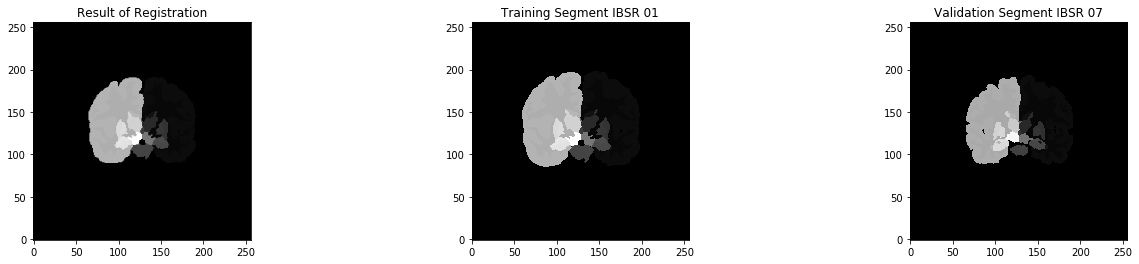

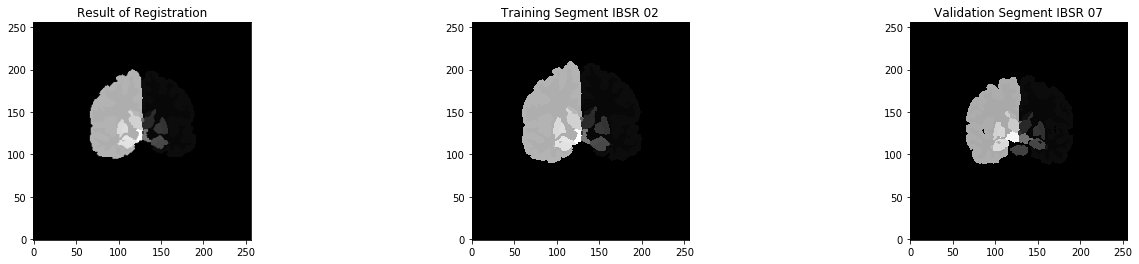

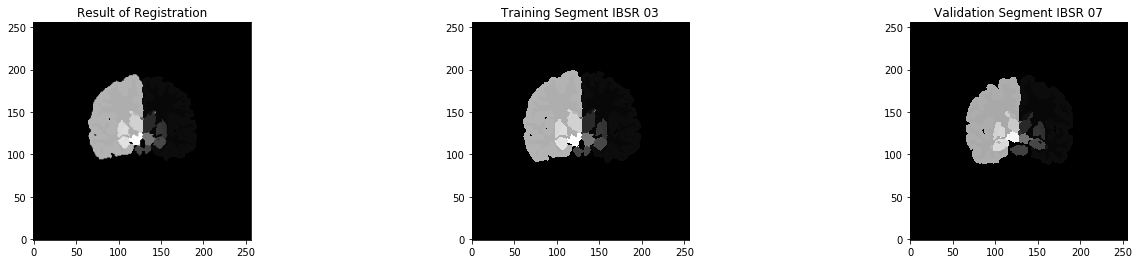

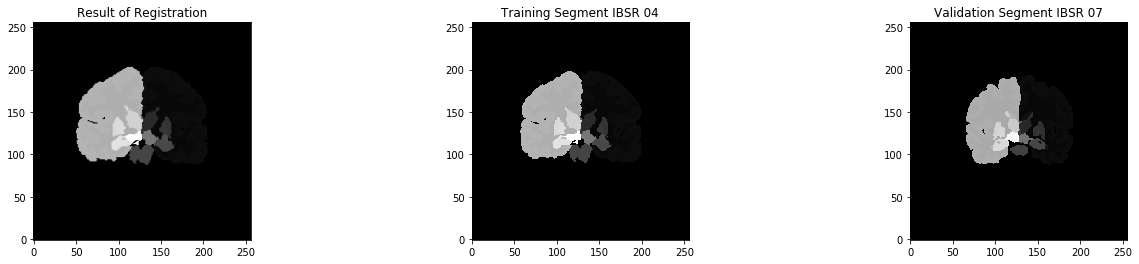

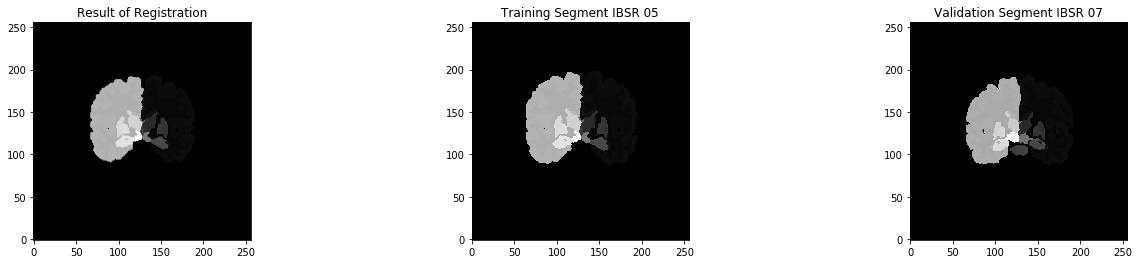

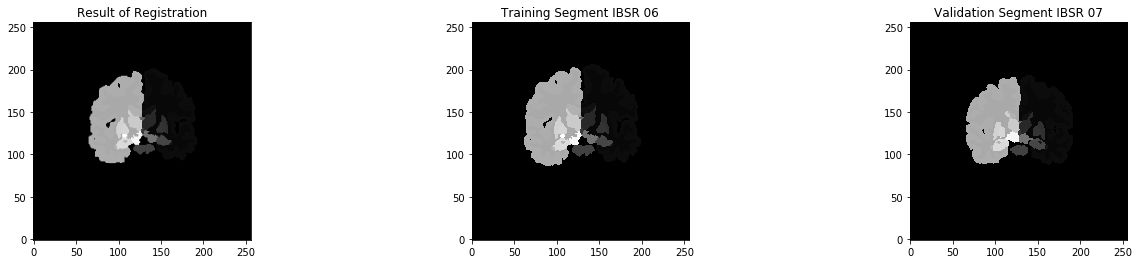

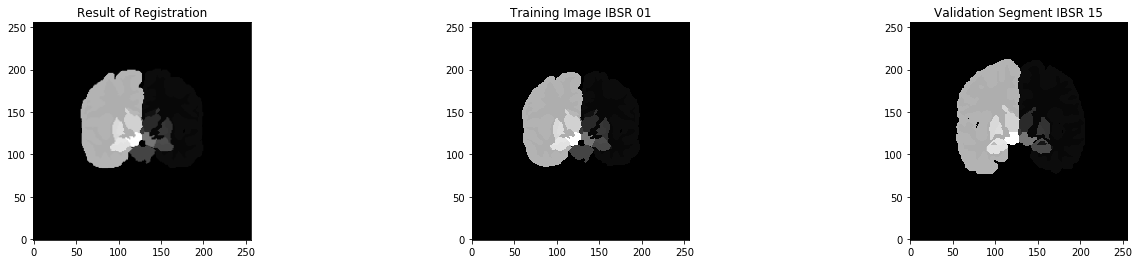

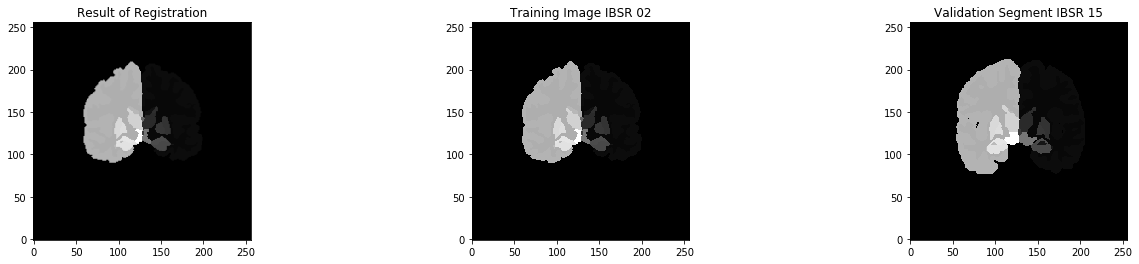

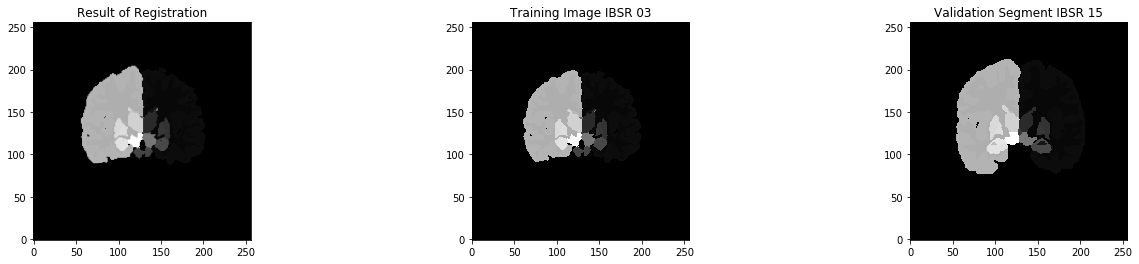

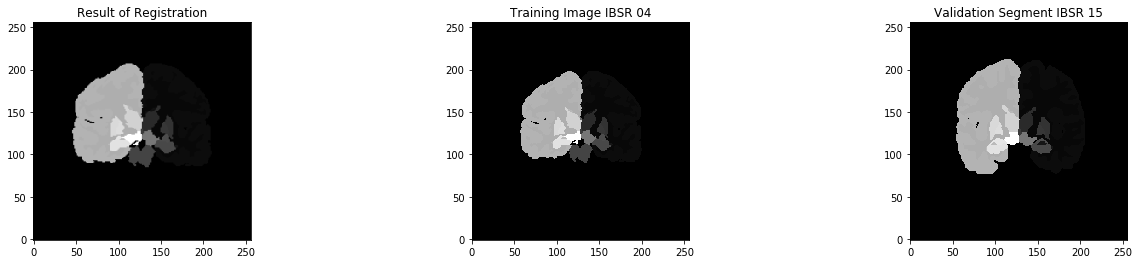

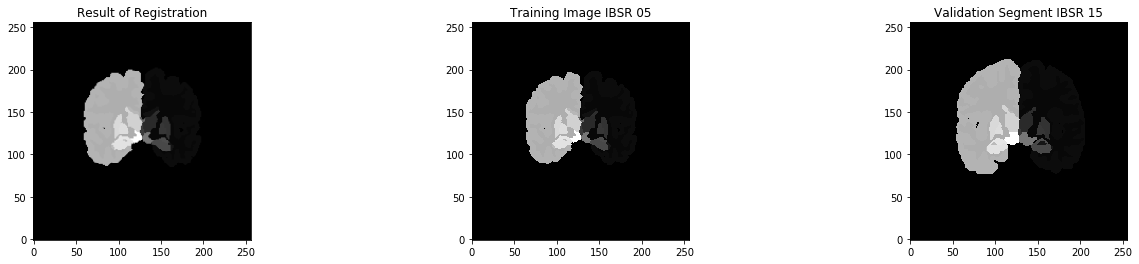

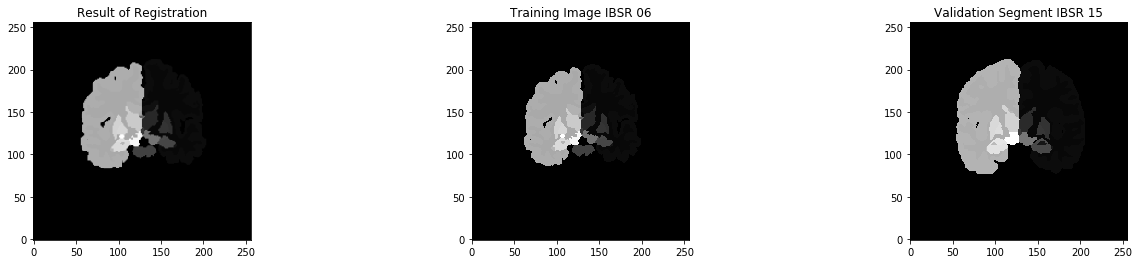

In [17]:
#PLOT STUFF

for i in range(len(seg_img_0)):
    fix, ax = plt.subplots(1, 3)
    ax[0].imshow(seg_img_0[i].squeeze(), cmap = 'gray', origin = 'lower')
    ax[0].set_title('Result of Registration')
    
    ax[1].imshow(training_segments[i].squeeze(), cmap = 'gray', origin = 'lower')
    ax[1].set_title('Training Segment IBSR 0' + str(i+1))
    
    ax[2].imshow(validation_segments[0].squeeze(), cmap = 'gray', origin = 'lower')
    ax[2].set_title('Validation Segment IBSR 07')
    plt.subplots_adjust(right = 3)
    
for i in range(len(seg_img_0)):
    fix, ax = plt.subplots(1, 3)
    ax[0].imshow(seg_img_1[i].squeeze(), cmap = 'gray', origin = 'lower')
    ax[0].set_title('Result of Registration')
    
    ax[1].imshow(training_segments[i].squeeze(), cmap = 'gray', origin = 'lower')
    ax[1].set_title('Training Image IBSR 0' + str(i+1))
    
    ax[2].imshow(validation_segments[1].squeeze(), cmap = 'gray', origin = 'lower')
    ax[2].set_title('Validation Segment IBSR 15')
    plt.subplots_adjust(right = 3)


plt.show()


<h2><center>4: Computing the Most Frequent Training Label for Every Pixel on Validation Subject Grid</center></h2>

 #### Making a "Set" of Images

In [18]:
"""
The v_0_set is the stack of the 6 training images mapped onto the first validation images grid (i.e a stack of 6 images)
The v_1_set is the stack of the 6 training images mapped onto the first validation images grid (i.e a stack of 6 images)
"""
#intialize a 256x256xj array of zeros such that each "level" j contains seg_img_X[j]
v_0_set = np.zeros((256,256,6)) #set of training segments mapped onto validation image IBSR 07 (vimg1)
v_1_set = np.zeros((256,256,6)) #set of training segments mapped onto validation image IBSR 15 (vimg2)

#store images in proper places
for j in range (6):
    v_0_set[:,:,j] = seg_img_0[j]
    v_1_set[:,:,j] = seg_img_1[j]
    
print(len(v_0_set))
print(len(v_0_set[0]))
print(len(v_0_set[0][0]))

256
256
6


### Computing Most Frequent Training Label

In [19]:
"""
MFTL computes the most frequent training label between a set of images. If there is a tie, a random one is chosen.

Want to compute the MODE between each pixel (m,n) at level j (m in [M], n in [N], j in [J]) for a "level-set" 
of images and store it in a new output image where each pixel (m,n) of the output image is the MODE

Input: J MxN images in an (M,N,J) array (J = 6)
Returns: Image where each pixel is the most frequent training label between each pixel [m][n] between all [j] levels
"""
def MFTL(img_set):
    M = len(img_set)
    N = len(img_set[0])
    J = len(img_set[0][0])
    
    #where to store output image
    output = np.zeros((256,256))
    #modeSet = [img_set[:,:,j] for j in range(J)]

    for m in range(M):
        for n in range(N):
            #compute the mode of pixel (m,n) between the j images
            mode, count = stats.mode([img_set[m][n][j] for j in range(J)])
            #mode, count = stats.mode([modeSet[k][m][n] for k in range(len(modeSet))])
            #the (m,n) output pixel is equal to that mode
            output[m][n] = mode
            
    return output

#### Visualize Results

Text(0.5, 1.0, 'Most Frequent Training Label of V_1 Set')

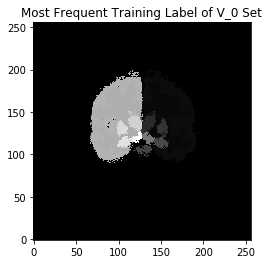

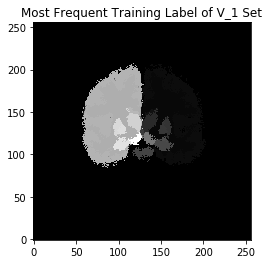

In [20]:
plt.figure(1)
v0_MFTL = MFTL(v_0_set) #MFTL of v_0_set
plt.imshow(v0_MFTL, cmap = 'gray', origin = 'lower')
plt.title('Most Frequent Training Label of V_0 Set')
plt.figure(2)
v1_MFTL = MFTL(v_1_set) #MFTL of v_1_set
plt.imshow(v1_MFTL, cmap = 'gray', origin = 'lower')
plt.title('Most Frequent Training Label of V_1 Set')

<h2><center>5: Writing a Jaccard Overlap Index Calculator</center></h2>

#### Jaccard Overlap Index := Area of Intersection/Area of Unions

In [21]:
"""
JOIC computes the Jaccarld Overlap index between a manual segmentation and an automatic segmentation for a specified
Region of Interest (ROI)

Inputs: - manual_segmentation: Manually segmented image
        - automatic_segmentation: Automatically segmented image
        - ROI: Specified region of interest

Output: Jaccard Overlap Index
"""
def JOIC(manual_segmentation, automatic_segmentation, ROI):
    
    #convert input images to np arrays of type int
    im1 = np.round(np.array(np.ndarray.flatten(manual_segmentation))).astype(int)
    im2 = np.round(np.array(np.ndarray.flatten(automatic_segmentation))).astype(int)
    
    #an array of shape MXN with a boolean in each (m,n) location which is True if the boolean expression evaluates to true, otherwise False
    bool_arr1 = (im1 == ROI)
    bool_arr2 = (im2 == ROI)
    
    #the intersection of im1 and im2 for specified ROI
    Intersection = np.logical_and(bool_arr1,bool_arr2)
    
    #the union of im1 and im2 for specified ROI
    Union = np.logical_or(bool_arr1, bool_arr2)
    
    return (np.sum(Intersection))/(np.sum(Union))

<h2><center>6: Computing the Jaccard Index for Automatic Validation Subject Segmentations</center></h2>

First I'll do all the computations and put it all in a table neatly at the end.

#### Computing Jaccard Index for Left-Cerebral-White-Matter (ROI =2)

In [22]:
print('Left Cerebral White Matter')

print('Most Frequent Training Label of V0 Set')
for i in range(len(validation_segments)):
    print(JOIC(v0_MFTL,validation_segments[i],2))
print('Most Frequent Training Label of V1 Set')
for i in range(len(validation_images)):
    print(JOIC(v1_MFTL,validation_segments[i],2))    

Left Cerebral White Matter
Most Frequent Training Label of V0 Set
0.5527522935779816
0.35511221945137156
Most Frequent Training Label of V1 Set
0.3932752927048934
0.5351033954557058


#### Computing Jaccard Index for Right-Cerebral-White-Matter (ROI=41)

In [23]:
print('Right Cerebral White Matter')

print('Most Frequent Training Label of V0 Set')
for i in range(len(validation_segments)):
    print(JOIC(v0_MFTL,validation_segments[i],41))
print('Most Frequent Training Label of V1 Set')
for i in range(len(validation_images)):
    print(JOIC(v1_MFTL,validation_segments[i],41))   

Right Cerebral White Matter
Most Frequent Training Label of V0 Set
0.5410933432502789
0.3696529459241324
Most Frequent Training Label of V1 Set
0.4141566265060241
0.5423728813559322


#### Computing Jaccard Index for Left-Cerebral-Cortex (ROI=3)

In [24]:
print('Left Cerebral Cortex')

print('Most Frequent Training Label of V0 Set')
for i in range(len(validation_segments)):
    print(JOIC(v0_MFTL,validation_segments[i],3))
print('Most Frequent Training Label of V1 Set')
for i in range(len(validation_images)):
    print(JOIC(v1_MFTL,validation_segments[i],3))    

Left Cerebral Cortex
Most Frequent Training Label of V0 Set
0.49200532978014655
0.20285065069200578
Most Frequent Training Label of V1 Set
0.2719449225473322
0.38777683134582625


#### Computing Jaccard Index for Right-Cerebral-Cortex (ROI=42)

In [25]:
print('Right Cerebral Cortex')

print('Most Frequent Training Label of V0 Set')
for i in range(len(validation_segments)):
    print(JOIC(v0_MFTL,validation_segments[i],42) )
print('Most Frequent Training Label of V1 Set')
for i in range(len(validation_images)):
    print(JOIC(v1_MFTL,validation_segments[i],42))    

Right Cerebral Cortex
Most Frequent Training Label of V0 Set
0.4555010511562719
0.2131766680654637
Most Frequent Training Label of V1 Set
0.2631027253668763
0.40295909486510006


### Making the Tables

<h4><center>Jaccard Index</center></h4>

<h5><center>Left Cerebral White Matter</center></h5>

|          -            |   Validation Segment IBSR 07  | Validation Segment IBSR 15  |     
|-----------------------|-------------------------------|-----------------------------|   
|      V0 MFTL Image    |       0.5527522935779816  |      0.35511221945137156     |
|      V1 MFTL Image    |      0.3932752927048934   |       0.5351033954557058    |

<h5><center>Right Cerebral White Matter</center></h5>

|          -            |   Validation Segment IBSR 07  | Validation Segment IBSR 15  |     
|-----------------------|-------------------------------|-----------------------------|   
|      V0 MFTL Image    |0.5410933432502789|0.3696529459241324|
|      V1 MFTL Image    |0.4141566265060241|0.5423728813559322|

<h5><center>Left Cerebral Cortex</center></h5>

|          -            |   Validation Segment IBSR 07  | Validation Segment IBSR 15  |     
|-----------------------|-------------------------------|-----------------------------|   
|      V0 MFTL Image    |0.49200532978014655|0.20285065069200578|
|      V1 MFTL Image    |0.2719449225473322|0.38777683134582625|

<h5><center>Right Cerebral Cortex</center></h5>

|          -            |   Validation Segment IBSR 07  | Validation Segment IBSR 15  |     
|-----------------------|-------------------------------|-----------------------------|   
|      V0 MFTL Image    |0.4555010511562719|0.2131766680654637|
|      V1 MFTL Image    |0.2631027253668763|0.40295909486510006|